<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Lightgbm" data-toc-modified-id="Lightgbm-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Lightgbm</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Lasso</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод." data-toc-modified-id="Вывод.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод.</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import seaborn as sns
import warnings
import time

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

## Подготовка

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()


data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Text(0.5, 1.0, 'Seasonality')

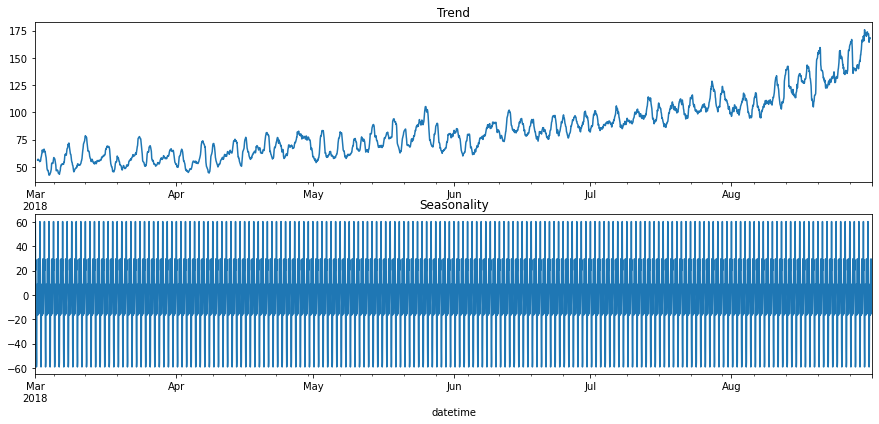

In [3]:
decomposed = seasonal_decompose(data)
    
plt.figure(figsize=(15, 10))
plt.subplot(311)
    
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
    
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
    

### Вывод
Есть повышение заказов к лету. Вероятнее всего это связано с тем что много людей летят отдыхать летом.<br>
Есть четко выраженная сезоность.<br>
По тренду мы видим, что пики постоянно происходят в воскресенье и понедельник.

In [4]:
def analize(data):
    data_to_plot = data['2018-03-01':'2018-04-01']
    
    data_to_plot['mean'] = data_to_plot['num_orders'].rolling(15).mean()
    data_to_plot['std'] = data_to_plot['num_orders'].rolling(15).std()
    data_to_plot.plot()
    warnings.filterwarnings("ignore")

<ipython-input-4-9435d5d3f532>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['mean'] = data_to_plot['num_orders'].rolling(15).mean()
<ipython-input-4-9435d5d3f532>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['std'] = data_to_plot['num_orders'].rolling(15).std()


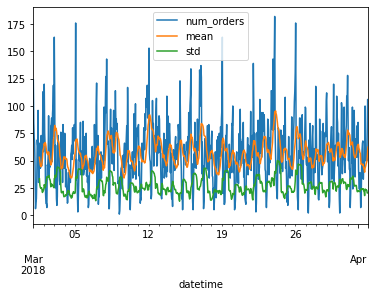

In [5]:
analize(data)

In [6]:
alpha = 0.05

if alpha < adfuller(data)[1]:
    print('Ряд не стационарен')
else: 
    print('Ряд стационарен')


Ряд стационарен


С помощью теста Дика Фуллера мы проверили что наш ряд стационарен.

## Обучение

In [7]:
def make_features_time(data, rolling_mean, lag_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean).mean()
    
    for lag in range(1, lag_size+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

        
make_features_time(data, 75, 20)



Функция для создания признаков: принцип скользящего среднего и лаги.

In [8]:

def make_features(features, target):
    features = features
    target =  target

    features_train, features_test, target_train, target_test = train_test_split(
                                        features, target, test_size=0.25, random_state=666)
    
    
    
    return features_train, features_test, target_train, target_test


def learn_model(models, features_train, features_test, target_train, target_test, title=''):
    
    def predict(model, train_predict, target_train, test_predict, target_test):
        
        metrics = {'RMSE' : mean_squared_error,
                   'MAE': mean_absolute_error,
                   'r2' : r2_score
                  }
        columns = ['train', 'test']
        data = []
        for metric in metrics.keys():
            if metric != 'RMSE':
                data.append([metrics[metric](target_train, train_predict) ,metrics[metric](target_test, test_predict)])
            else:
                data.append([metrics[metric](target_train, train_predict)**0.5 ,metrics[metric](target_test, test_predict)**0.5])
                


        results = pd.DataFrame(data=data, index=metrics.keys(), columns=columns)
        
        print(results)
        print()
    
    def fit_model():
        

        plot_data = {}
        learned_model = {}
        
        for model in models.keys():
            print(f'__________{model}__________')
            model_learn = models[model][0]
            params = models[model][1]
            
            start_time = time.time()
            
            grid = GridSearchCV(model_learn, cv=TimeSeriesSplit(n_splits=5), param_grid=params, n_jobs=-1)
            grid.fit(features_train, target_train)
            end_time = time.time()
            fit_time = end_time - start_time
            
            plot_data[model] = fit_time # время обучения модели
            learned_model[model] = [grid, grid.best_params_] # сохраняем модель
            
            
            
            train_predict = grid.predict(features_train)
            test_predict = grid.predict(features_test)
            
            predicted = predict(model, train_predict, target_train, test_predict, target_test)
            
            
        sns.barplot(x=list(plot_data.keys()), y=list(plot_data.values()), saturation=1)    
        plt.xlabel('Модели')
        plt.ylabel('Время')
        plt.title(f'Время обучения {title}')
        plt.show()
        
        return learned_model
        
        
    result_model = fit_model()    
    
    
        
    return result_model
            


In [9]:
models = {'Linear' : [LinearRegression(n_jobs=-1), {}],
          
          'Forest' : [RandomForestRegressor(n_jobs=-1), {'max_depth':range(1, 10, 4),
                                                         'min_samples_leaf':range(1, 7, 3),
                                                         'min_samples_split':range (2, 10,4), 
                                                         'n_estimators':range(10, 110, 10)}],
          'LightGBM' : [LGBMRegressor(n_jobs=-1), {'learning_rate':[0.001, 0.01, 0.1], 
                                                   'max_depth':range(1, 15, 1),
                                                   'n_estimators':range(1, 101, 25)}],
          
          'CatBoost' : [CatBoostRegressor(silent=True, iterations=40), {'learning_rate':[0.001, 0.01, 0.1], 
                                                                          'depth':range(1, 15, 1)}]
         }

Модели и их параметры.

In [10]:
data = data.dropna()

target = data['num_orders']
features = data.drop('num_orders', axis=1)

features_train, features_test, target_train, target_test = make_features(features, target)

print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(3255, 24) (1086, 24)
(3255,) (1086,)


разделили данные на обучающую и тестовую выборку.

__________Linear__________
          train       test
RMSE  31.395411  31.386167
MAE   23.830770  24.021474
r2     0.518069   0.505689

__________Forest__________
          train       test
RMSE  19.898363  28.703435
MAE   14.477676  21.528046
r2     0.806408   0.586580

__________LightGBM__________
          train       test
RMSE  16.501221  26.943592
MAE   12.555908  20.302408
r2     0.866867   0.635721

__________CatBoost__________
          train       test
RMSE  23.821352  28.575183
MAE   18.253779  21.709381
r2     0.722550   0.590266



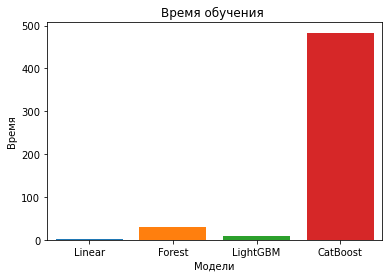

Wall time: 8min 43s


In [11]:
%%time
models = learn_model(models, features_train, features_test, target_train, target_test)

In [12]:
model_LightGBM = models['LightGBM'][0]

Сохранил модель с лучшим показателем в переменую `model_LightGBM`

In [13]:
models['LightGBM'][1]

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 76}

Параметры для модели LightGBM.

## Вывод.

Лучший результат был достигнут с помощью градиентного бустинга LightGBM.
1. Наилучший результат, по сравнению с другими моделями.
2. У него больше скорость обратботки по сравнению с другими моделями.


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48